In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import cv2

!pip install trackpy
import trackpy as tp

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import statistics

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for trackpy: filename=trackpy-0.6.1-py3-none-any.whl size=129688 sha256=e1be747c7ad281f45d2b641b16353832e7e40a7fa944b8442778786eca270557
  Stored in directory: /root/.cache/pip/wheels/98/21/03/2cc216865a74deaea716585db22b45e13dce76afd354ea7250
Successfully built trackpy
Mounted at /content/drive


In [ ]:
# Detect when OKT3 was added
video_dir = '/content/drive/MyDrive/Database/testing_calcium_assay_jpg/videos'
OKT3_add_ts = {'fileName':[], 'OKT3_add_t':[]}
items = os.listdir(video_dir)
for x in range(len(items)):
    test_video_path = os.path.join(video_dir+'/'+items[x])
    mean_b = []
    vid = cv2.VideoCapture(test_video_path)
    for i in range(1000):
        ret, frame = vid.read() # ret means whether there is a frame or not, frame is nd.array 968x548x3
        # mean_np.append(np.expand_dims(frame, axis=0))
        mean_b.append(np.mean(frame))
    mean_b[:400] = [0]*400
    OKT3_add_t = mean_b.index(max(mean_b))
    OKT3_add_ts['fileName'].append(items[x])
    OKT3_add_ts['OKT3_add_t'].append(OKT3_add_t)

    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()

Frame 999: 87 trajectories present.


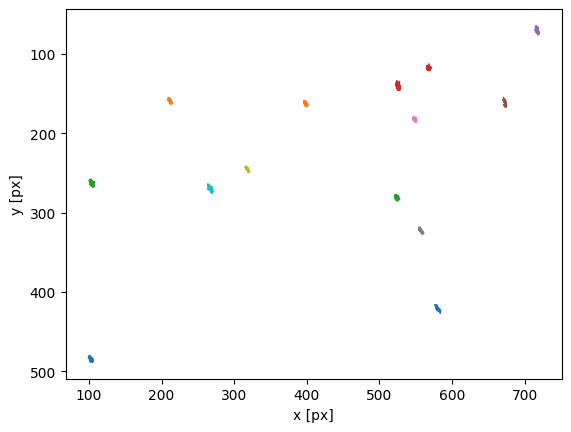

<Figure size 640x480 with 0 Axes>

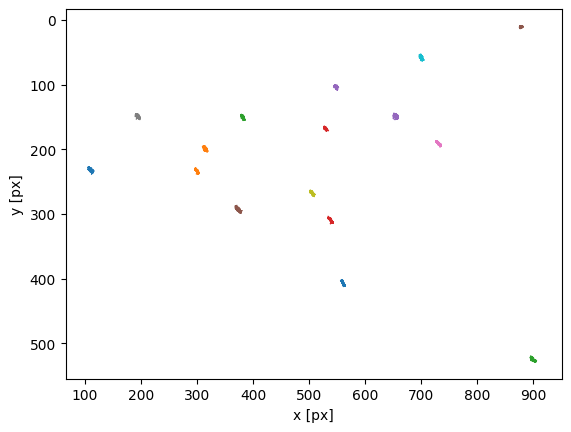

<Figure size 640x480 with 0 Axes>

background is63.20579029733959
background is42.182367149758456


In [ ]:
############################################################################################################################
### Considering sample mechanical drifts, the number of cells imaged before and after adding OKT3 can be very different ####
############################################################################################################################
csv_dir = '/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results'
OKT3_add_ts_df = pd.DataFrame.from_dict(OKT3_add_ts)
results = {'fileName':[], 'OKT3_add_t':[], 'Total_Number_of_cells_before_OKT3':[], 'Activated_before_OKT3':[],'Total_Number_of_cells_after_OKT3':[], 'Activated_after_OKT3':[]}
items = os.listdir(csv_dir)
for x in range(len(items)):
  if items[x].endswith('.avi.csv'):
    OKT3_add_df = OKT3_add_ts_df[OKT3_add_ts_df['fileName'] == items[x][:-4]]
    OKT3_add = OKT3_add_df['OKT3_add_t'].to_numpy()[0]
    # Get trajects from box information
    csv_path = os.path.join(csv_dir+'/'+items[x])
    box_infos_df = pd.read_csv(csv_path)
    box_infos_df = box_infos_df[box_infos_df['score']>=0.2]
    box_infos_df_before = box_infos_df[box_infos_df['frame']<OKT3_add]
    box_infos_df_after = box_infos_df[box_infos_df['frame']>=OKT3_add]
    trajects_before = tp.link(box_infos_df_before, search_range = 5, memory = 100)
    trajects_after = tp.link(box_infos_df_after, search_range = 5, memory = 50)
    trajects_before = tp.filter_stubs(trajects_before, 300)
    trajects_after = tp.filter_stubs(trajects_after, 200)
    trajects_before.to_csv('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+ items[x] + '_trajects_before_OKT3.csv')
    trajects_after.to_csv('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+ items[x] + '_trajects_after_OKT3.csv')

    # if len(trajects)<5:
    #   continue

    # %matplotlib inline
    plt.figure()
    tp.plot_traj(trajects_before);
    # img_path = os.path.join(csv_dir+'/'+items[x][:-8]+'_before.png');
    # plt.savefig(img_path)

    plt.figure()
    tp.plot_traj(trajects_after);
    # img_path = os.path.join(csv_dir+'/'+items[x][:-8]+'_after.png');
    # plt.savefig(img_path)

    plt.show()

    # Estimate background level
    bk1 = statistics.mean(sorted(trajects_before['mean_brightness'])[0:len(trajects_before['mean_brightness'])//100])
    print('background is'+str(bk1))
    trajects_before['mean_brightness'] = trajects_before['mean_brightness']-bk
    bk2 = statistics.mean(sorted(trajects_after['mean_brightness'])[0:len(trajects_after['mean_brightness'])//100])
    print('background is'+str(bk2))
    trajects_after['mean_brightness'] = trajects_after['mean_brightness']-bk

    # Define cells as remaining trajectories, Interpolate cell brightness
    cell_infos = {'cell_idx_before':[], 'mean_brightness_before':[], 'spike_start_locs_before':[], 'spike_peak_locs_before':[],'cell_idx_after':[], 'mean_brightness_after':[], 'spike_start_locs_after':[], 'spike_peak_locs_after':[], 'activated_after_OKT3':[], 'activated_before_OKT3':[]}
    ########## Analyze cells detected before adding in OKT3 ######################
    n1 = 0
    for i in trajects_before['particle'].unique():
      ###########################################################################
      # identify long-enough trajects of cells, interpolate missing values
      cell = trajects_before[trajects_before['particle'] == i]
      f = list(cell['frame'])
      b = list(cell['mean_brightness'])
      f_interp = range(0,OKT3_add)
      b_interp = np.interp(f_interp,f,b)
      cell_infos['cell_idx_before'].append(n)
      cell_infos['mean_brightness_before'].append(b_interp)
      cell_infos['activated_before_OKT3'].append(0)

      ##########################################################################
      # find the start points and peak points of spikes, by locating 0s in grads
      b_smooth = gaussian_filter1d(b_interp,sigma = 5)
      b_s_grad = np.gradient(b_smooth)
      peak_grad_locs, properties = find_peaks(b_s_grad, height=0.5, prominence=1)

      zero_grad_locs = np.where(b_s_grad[1:]*b_s_grad[:-1] <= 0)[0]
      spike_start_locs, spike_peak_locs = [],[]
      if peak_grad_locs.size != 0:
          for peak_grad_loc in peak_grad_locs:
            if (zero_grad_locs[zero_grad_locs < peak_grad_loc].size)*(zero_grad_locs[zero_grad_locs > peak_grad_loc].size) !=0 :
              spike_start_loc = max(zero_grad_locs[zero_grad_locs < peak_grad_loc])
              spike_peak_loc = min(zero_grad_locs[zero_grad_locs > peak_grad_loc])
              # spike_finish_loc = min(zero_grad_locs[zero_grad_locs > spike_peak_loc])
              if b_interp[spike_peak_loc] >= 2* b_interp[spike_start_loc]: # or ((b_interp[spike_peak_loc] >= 1.5* b_interp[spike_start_loc]) and (spike_finish_loc-spike_start_loc>=100)):
                  f_all = set(range(spike_start_loc,spike_peak_loc))
                  f_real = set(f) & f_all
                  if len(f_real) >= 0.6*len(f_all) and spike_peak_loc < OKT3_add-30:
                      cell_infos['activated_before_OKT3'][n1] += 1
                      spike_start_locs.append(spike_start_loc)
                      spike_peak_locs.append(spike_peak_loc)
          cell_infos['spike_start_locs_before'].append(spike_start_locs)
          cell_infos['spike_peak_locs_before'].append(spike_peak_locs)
          # ###########################################################################
          # # plot bighness values, their grads and automatically recogized spikes.
          # plt.figure().set_figwidth(5)
          # plt.plot(range(0,OKT3_add), b_s_grad)
          # plt.vlines(x=peak_grad_locs, ymin=b_s_grad[peak_grad_locs] - properties["prominences"],
          #         ymax = b_s_grad[peak_grad_locs], color = "C1")
          # plt.show()

          # plt.figure().set_figwidth(15)
          # plt.plot(range(0,OKT3_add), b_interp)
          # plt.plot(spike_start_locs,b_interp[spike_start_locs], "x")
          # plt.plot(spike_peak_locs,b_interp[spike_peak_locs], "o")
          # plt.show()
          # ###########################################################################
      n1 += 1


    ########## Analyze cells detected after adding in OKT3 ######################
    n2 = 0
    for i in trajects_after['particle'].unique():
      ###########################################################################
      # identify long-enough trajects of cells, interpolate missing values
      cell = trajects_after[trajects_after['particle'] == i]
      f = list(cell['frame'])
      b = list(cell['mean_brightness'])
      f_interp = range(OKT3_add,1000)
      b_interp = np.interp(f_interp,f,b)
      cell_infos['cell_idx_after'].append(n)
      cell_infos['mean_brightness_after'].append(b_interp)
      cell_infos['activated_after_OKT3'].append(0)
      ##########################################################################
      # find the start points and peak points of spikes, by locating 0s and maximums in grads
      b_smooth = gaussian_filter1d(b_interp,sigma = 5)
      b_s_grad = np.gradient(b_smooth)
      peak_grad_locs, properties = find_peaks(b_s_grad, height=0.5, prominence=1)

      zero_grad_locs = np.where(b_s_grad[1:]*b_s_grad[:-1] <= 0)[0]
      spike_start_locs, spike_peak_locs = [],[]
      if peak_grad_locs.size != 0:
          for peak_grad_loc in peak_grad_locs:
            if (zero_grad_locs[zero_grad_locs < peak_grad_loc].size)*(zero_grad_locs[zero_grad_locs > peak_grad_loc].size) !=0 :
              spike_start_loc = max(zero_grad_locs[zero_grad_locs < peak_grad_loc])
              spike_peak_loc = min(zero_grad_locs[zero_grad_locs > peak_grad_loc])
              # spike_finish_loc = min(zero_grad_locs[zero_grad_locs > spike_peak_loc])
              if b_interp[spike_peak_loc] >= 2* b_interp[spike_start_loc]: # or ((b_interp[spike_peak_loc] >= 1.5* b_interp[spike_start_loc]) and (spike_finish_loc-spike_start_loc>=100)):
                  cell_infos['activated_after_OKT3'][n2] += 1
                  spike_start_locs.append(spike_start_loc)
                  spike_peak_locs.append(spike_peak_loc)
          cell_infos['spike_start_locs_after'].append(spike_start_locs)
          cell_infos['spike_peak_locs_after'].append(spike_peak_locs)
          # ###########################################################################
          # # plot bighness values, their grads and automatically recogized spikes.
          # plt.figure().set_figwidth(5)
          # plt.plot(range(0,1000-OKT3_add), b_s_grad)
          # plt.vlines(x=peak_grad_locs, ymin=b_s_grad[peak_grad_locs] - properties["prominences"],
          #         ymax = b_s_grad[peak_grad_locs], color = "C1")
          # plt.show()

          # plt.figure().set_figwidth(15)
          # plt.plot(range(0,1000-OKT3_add), b_interp)
          # plt.plot(spike_start_locs,b_interp[spike_start_locs], "x")
          # plt.plot(spike_peak_locs,b_interp[spike_peak_locs], "o")
          # plt.show()
          # ###########################################################################
      n2 += 1

    N_cells_activate_before_OKT3 = np.count_nonzero(cell_infos['activated_before_OKT3'])
    N_cells_activate_after_OKT3 = np.count_nonzero(cell_infos['activated_after_OKT3'])
    # print('Total Number of cells detected before adding in OKT3:' + str(n1) + ', ' + str(N_cells_activate_before_OKT3 ) + ' activated before adding OKT3, ' + str(N_cells_activate_after_OKT3 ) + ' activated after adding OKT3.')

    results['fileName'].append(items[x])
    results['OKT3_add_t'].append(OKT3_add)
    results['Total_Number_of_cells_before_OKT3'].append(n1)
    results['Total_Number_of_cells_after_OKT3'].append(n2)
    results['Activated_before_OKT3'].append(N_cells_activate_before_OKT3)
    results['Activated_after_OKT3'].append(N_cells_activate_after_OKT3)

    # cell_infos_df = pd.DataFrame.from_dict(cell_infos)
    # cells_results_path = os.path.join('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+'cell_test' + '.csv')
    # cell_infos_df.to_csv(cells_results_path)

results_df = pd.DataFrame.from_dict(results)
results_path = os.path.join('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+'results_all' + '.csv')
results_df.to_csv(results_path)

In [ ]:
# Assume sample mechanical drift is neglectable
csv_dir = '/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results'
OKT3_add_ts_df = pd.DataFrame.from_dict(OKT3_add_ts)
results = {'fileName':[], 'OKT3_add_t':[], 'Total_Number_of_cells':[], 'Activated_before_OKT3':[], 'Activated_after_OKT3':[]}
items = os.listdir(csv_dir)
for x in range(len(items)):
  if items[x].endswith('.avi.csv'):
    # Get trajects from box information
    csv_path = os.path.join(csv_dir+'/'+items[x])
    box_infos_df = pd.read_csv(csv_path)
    box_infos_df = box_infos_df[box_infos_df['score']>=0.2]
    trajects = tp.link(box_infos_df, search_range = 10, memory = 400)
    trajects.to_csv('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+ items[x] + '_trajects.csv')
    trajects = tp.filter_stubs(trajects, 600)

    if len(trajects)<5:
      continue

    # %matplotlib inline
    plt.figure()
    tp.plot_traj(trajects);
    plt.show()

    # Estimate background level
    bk = statistics.mean(sorted(trajects['mean_brightness'])[0:len(trajects['mean_brightness'])//100])
    print('background is'+str(bk))
    trajects['mean_brightness'] = trajects['mean_brightness']-bk

    # Define cells as remaining trajectories, Interpolate cell brightness
    cell_infos = {'cell_idx':[], 'mean_brightness':[], 'spike_start_locs':[], 'spike_peak_locs':[], 'activated_after_OKT3':[], 'activated_before_OKT3':[]}
    # OKT3_add = [OKT3_add_ts['OKT3_add_t'][a] for a in range(len(OKT3_add_ts['fileName'])) if OKT3_add_ts['fileName'][a] == items[x][:-4]]
    OKT3_add_df = OKT3_add_ts_df[OKT3_add_ts_df['fileName'] == items[x][:-4]]
    OKT3_add = OKT3_add_df['OKT3_add_t'].to_numpy()[0]

    n = 0
    for i in trajects['particle'].unique():
      ###########################################################################
      # identify long-enough trajects of cells, interpolate missing values
      cell = trajects[trajects['particle'] == i]
      f = list(cell['frame'])
      b = list(cell['mean_brightness'])
      f_interp = range(1000)
      b_interp = np.interp(f_interp,f,b)
      cell_infos['cell_idx'].append(n)
      cell_infos['mean_brightness'].append(b_interp)
      cell_infos['activated_before_OKT3'].append(0)
      cell_infos['activated_after_OKT3'].append(0)

      ##########################################################################
      # find the start points and peak points of spikes, by locating 0s in grads
      b_smooth = gaussian_filter1d(b_interp,sigma = 5)
      b_s_grad = np.gradient(b_smooth)
      peak_grad_locs, properties = find_peaks(b_s_grad, height=0.5, prominence=1)

      zero_grad_locs = np.where(b_s_grad[1:]*b_s_grad[:-1] <= 0)[0]
      spike_start_locs, spike_peak_locs = [],[]
      if peak_grad_locs.size != 0:
          for peak_grad_loc in peak_grad_locs:
            if (zero_grad_locs[zero_grad_locs < peak_grad_loc].size)*(zero_grad_locs[zero_grad_locs > peak_grad_loc].size) !=0 :
              spike_start_loc = max(zero_grad_locs[zero_grad_locs < peak_grad_loc])
              spike_peak_loc = min(zero_grad_locs[zero_grad_locs > peak_grad_loc])
              spike_start_locs.append(spike_start_loc)
              spike_peak_locs.append(spike_peak_loc)
              if b_interp[spike_peak_loc] >= 2* b_interp[spike_start_loc]:
                  if spike_peak_loc > OKT3_add:
                      cell_infos['activated_after_OKT3'][n] += 1
                  elif spike_peak_loc < OKT3_add-30:
                      cell_infos['activated_before_OKT3'][n] += 1

          cell_infos['spike_start_locs'].append(spike_start_locs)
          cell_infos['spike_peak_locs'].append(spike_peak_locs)

      ############################################################################
      # # plot bighness values, their grads and automatically recogized spikes.
      # plt.figure().set_figwidth(5)
      # plt.plot(f_interp, b_s_grad)
      # plt.vlines(x=peak_grad_locs, ymin=b_s_grad[peak_grad_locs] - properties["prominences"],
      #          ymax = b_s_grad[peak_grad_locs], color = "C1")
      # plt.show()

      # plt.figure().set_figwidth(15)
      # plt.plot(f_interp, b_interp)
      # plt.plot(spike_start_locs,b_interp[spike_start_locs], "x")
      # plt.plot(spike_peak_locs,b_interp[spike_peak_locs], "o")
      # plt.show()
      ############################################################################

      n += 1

    N_cells_activate_before_OKT3 = np.count_nonzero(cell_infos['activated_before_OKT3'])
    N_cells_activate_after_OKT3 = np.count_nonzero(cell_infos['activated_after_OKT3'])
    print('Total Number of cells:' + str(n) + ', ' + str(N_cells_activate_before_OKT3 ) + ' activated before adding OKT3, ' + str(N_cells_activate_after_OKT3 ) + ' activated after adding OKT3.')

    results['fileName'].append(items[x])
    results['OKT3_add_t'].append(OKT3_add)
    results['Total_Number_of_cells'].append(n)
    results['Activated_before_OKT3'].append(N_cells_activate_before_OKT3)
    results['Activated_after_OKT3'].append(N_cells_activate_after_OKT3)

    # cell_infos_df = pd.DataFrame.from_dict(cell_infos)
    # cells_results_path = os.path.join('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+'cell_test' + '.csv')
    # cell_infos_df.to_csv(cells_results_path)

results_df = pd.DataFrame.from_dict(results)
results_path = os.path.join('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+'results_all' + '.csv')
results_df.to_csv(results_path)

In [ ]:
############################################################################################################################
### single loop separate ####
############################################################################################################################
csv_dir = '/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results'
OKT3_add_ts_df = pd.DataFrame.from_dict(OKT3_add_ts)
results = {'fileName':[], 'OKT3_add_t':[], 'Total_Number_of_cells_before_OKT3':[], 'Activated_before_OKT3':[],'Total_Number_of_cells_after_OKT3':[], 'Activated_after_OKT3':[]}
items = os.listdir(csv_dir)
for x in range(8,9):
  if items[x].endswith('.avi.csv'):
    OKT3_add_df = OKT3_add_ts_df[OKT3_add_ts_df['fileName'] == items[x][:-4]]
    OKT3_add = OKT3_add_df['OKT3_add_t'].to_numpy()[0]
    # Get trajects from box information
    csv_path = os.path.join(csv_dir+'/'+items[x])
    box_infos_df = pd.read_csv(csv_path)
    box_infos_df = box_infos_df[box_infos_df['score']>=0.2]
    box_infos_df_before = box_infos_df[box_infos_df['frame']<OKT3_add]
    box_infos_df_after = box_infos_df[box_infos_df['frame']>=OKT3_add]
    trajects_before = tp.link(box_infos_df_before, search_range = 5, memory = 100)
    trajects_after = tp.link(box_infos_df_after, search_range = 5, memory = 50)
    trajects_before = tp.filter_stubs(trajects_before, 300)
    trajects_after = tp.filter_stubs(trajects_after, 200)
    trajects_before.to_csv('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+ items[x] + '_trajects_before_OKT3.csv')
    trajects_after.to_csv('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+ items[x] + '_trajects_after_OKT3.csv')

    # if len(trajects)<5:
    #   continue

    # %matplotlib inline
    plt.figure()
    tp.plot_traj(trajects_before);
    img_path = os.path.join(csv_dir+'/'+items[x][:-8]+'_before.png');
    plt.savefig(img_path)

    plt.figure()
    tp.plot_traj(trajects_after);
    img_path = os.path.join(csv_dir+'/'+items[x][:-8]+'_after.png');
    plt.savefig(img_path)

    plt.show()

    # Estimate background level
    bk1 = statistics.mean(sorted(trajects_before['mean_brightness'])[0:len(trajects_before['mean_brightness'])//100])
    print('background is'+str(bk1))
    trajects_before['mean_brightness'] = trajects_before['mean_brightness']-bk
    bk2 = statistics.mean(sorted(trajects_after['mean_brightness'])[0:len(trajects_after['mean_brightness'])//100])
    print('background is'+str(bk2))
    trajects_after['mean_brightness'] = trajects_after['mean_brightness']-bk

    # Define cells as remaining trajectories, Interpolate cell brightness
    cell_infos = {'cell_idx_before':[], 'mean_brightness_before':[], 'spike_start_locs_before':[], 'spike_peak_locs_before':[],'cell_idx_after':[], 'mean_brightness_after':[], 'spike_start_locs_after':[], 'spike_peak_locs_after':[], 'activated_after_OKT3':[], 'activated_before_OKT3':[]}
    ########## Analyze cells detected before adding in OKT3 ######################
    n1 = 0
    for i in trajects_before['particle'].unique():
      ###########################################################################
      # identify long-enough trajects of cells, interpolate missing values
      cell = trajects_before[trajects_before['particle'] == i]
      f = list(cell['frame'])
      b = list(cell['mean_brightness'])
      f_interp = range(0,OKT3_add)
      b_interp = np.interp(f_interp,f,b)
      cell_infos['cell_idx_before'].append(n)
      cell_infos['mean_brightness_before'].append(b_interp)
      cell_infos['activated_before_OKT3'].append(0)

      ##########################################################################
      # find the start points and peak points of spikes, by locating 0s in grads
      b_smooth = gaussian_filter1d(b_interp,sigma = 5)
      b_s_grad = np.gradient(b_smooth)
      peak_grad_locs, properties = find_peaks(b_s_grad, height=0.5, prominence=1)

      zero_grad_locs = np.where(b_s_grad[1:]*b_s_grad[:-1] <= 0)[0]
      spike_start_locs, spike_peak_locs = [],[]
      if peak_grad_locs.size != 0:
          for peak_grad_loc in peak_grad_locs:
            if (zero_grad_locs[zero_grad_locs < peak_grad_loc].size)*(zero_grad_locs[zero_grad_locs > peak_grad_loc].size) !=0 :
              spike_start_loc = max(zero_grad_locs[zero_grad_locs < peak_grad_loc])
              spike_peak_loc = min(zero_grad_locs[zero_grad_locs > peak_grad_loc])
              # spike_finish_loc = min(zero_grad_locs[zero_grad_locs > spike_peak_loc])
              if b_interp[spike_peak_loc] >= 2* b_interp[spike_start_loc]: # or ((b_interp[spike_peak_loc] >= 1.5* b_interp[spike_start_loc]) and (spike_finish_loc-spike_start_loc>=100)):
                  f_all = set(range(spike_start_loc,spike_peak_loc))
                  f_real = set(f) & f_all
                  if len(f_real) >= 0.6*len(f_all) and spike_peak_loc < OKT3_add-30:
                      cell_infos['activated_before_OKT3'][n1] += 1
                      spike_start_locs.append(spike_start_loc)
                      spike_peak_locs.append(spike_peak_loc)
          cell_infos['spike_start_locs_before'].append(spike_start_locs)
          cell_infos['spike_peak_locs_before'].append(spike_peak_locs)
          ###########################################################################
          # plot bighness values, their grads and automatically recogized spikes.
          plt.figure().set_figwidth(5)
          plt.plot(range(0,OKT3_add), b_s_grad)
          plt.vlines(x=peak_grad_locs, ymin=b_s_grad[peak_grad_locs] - properties["prominences"],
                  ymax = b_s_grad[peak_grad_locs], color = "C1")
          plt.show()

          plt.figure().set_figwidth(15)
          plt.plot(range(0,OKT3_add), b_interp)
          plt.plot(spike_start_locs,b_interp[spike_start_locs], "x")
          plt.plot(spike_peak_locs,b_interp[spike_peak_locs], "o")
          plt.show()
          ###########################################################################
      n1 += 1


    ########## Analyze cells detected after adding in OKT3 ######################
    n2 = 0
    for i in trajects_after['particle'].unique():
      ###########################################################################
      # identify long-enough trajects of cells, interpolate missing values
      cell = trajects_after[trajects_after['particle'] == i]
      f = list(cell['frame'])
      b = list(cell['mean_brightness'])
      f_interp = range(OKT3_add,1000)
      b_interp = np.interp(f_interp,f,b)
      cell_infos['cell_idx_after'].append(n)
      cell_infos['mean_brightness_after'].append(b_interp)
      cell_infos['activated_after_OKT3'].append(0)
      ##########################################################################
      # find the start points and peak points of spikes, by locating 0s and maximums in grads
      b_smooth = gaussian_filter1d(b_interp,sigma = 5)
      b_s_grad = np.gradient(b_smooth)
      peak_grad_locs, properties = find_peaks(b_s_grad, height=0.5, prominence=1)

      zero_grad_locs = np.where(b_s_grad[1:]*b_s_grad[:-1] <= 0)[0]
      spike_start_locs, spike_peak_locs = [],[]
      if peak_grad_locs.size != 0:
          for peak_grad_loc in peak_grad_locs:
            if (zero_grad_locs[zero_grad_locs < peak_grad_loc].size)*(zero_grad_locs[zero_grad_locs > peak_grad_loc].size) !=0 :
              spike_start_loc = max(zero_grad_locs[zero_grad_locs < peak_grad_loc])
              spike_peak_loc = min(zero_grad_locs[zero_grad_locs > peak_grad_loc])
              # spike_finish_loc = min(zero_grad_locs[zero_grad_locs > spike_peak_loc])
              if b_interp[spike_peak_loc] >= 2* b_interp[spike_start_loc]: # or ((b_interp[spike_peak_loc] >= 1.5* b_interp[spike_start_loc]) and (spike_finish_loc-spike_start_loc>=100)):
                  cell_infos['activated_after_OKT3'][n2] += 1
                  spike_start_locs.append(spike_start_loc)
                  spike_peak_locs.append(spike_peak_loc)
          cell_infos['spike_start_locs_after'].append(spike_start_locs)
          cell_infos['spike_peak_locs_after'].append(spike_peak_locs)
          ###########################################################################
          # plot bighness values, their grads and automatically recogized spikes.
          plt.figure().set_figwidth(5)
          plt.plot(range(0,1000-OKT3_add), b_s_grad)
          plt.vlines(x=peak_grad_locs, ymin=b_s_grad[peak_grad_locs] - properties["prominences"],
                  ymax = b_s_grad[peak_grad_locs], color = "C1")
          plt.show()

          plt.figure().set_figwidth(15)
          plt.plot(range(0,1000-OKT3_add), b_interp)
          plt.plot(spike_start_locs,b_interp[spike_start_locs], "x")
          plt.plot(spike_peak_locs,b_interp[spike_peak_locs], "o")
          plt.show()
          ###########################################################################
      n2 += 1

    N_cells_activate_before_OKT3 = np.count_nonzero(cell_infos['activated_before_OKT3'])
    N_cells_activate_after_OKT3 = np.count_nonzero(cell_infos['activated_after_OKT3'])
    # print('Total Number of cells detected before adding in OKT3:' + str(n1) + ', ' + str(N_cells_activate_before_OKT3 ) + ' activated before adding OKT3, ' + str(N_cells_activate_after_OKT3 ) + ' activated after adding OKT3.')

    results['fileName'].append(items[x])
    results['OKT3_add_t'].append(OKT3_add)
    results['Total_Number_of_cells_before_OKT3'].append(n1)
    results['Total_Number_of_cells_after_OKT3'].append(n2)
    results['Activated_before_OKT3'].append(N_cells_activate_before_OKT3)
    results['Activated_after_OKT3'].append(N_cells_activate_after_OKT3)

    # cell_infos_df = pd.DataFrame.from_dict(cell_infos)
    # cells_results_path = os.path.join('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+'cell_test' + '.csv')
    # cell_infos_df.to_csv(cells_results_path)

results_df = pd.DataFrame.from_dict(results)
results_path = os.path.join('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+'results_single_loop' + '.csv')
results_df.to_csv(results_path)

Output hidden; open in https://colab.research.google.com to view.

In [3]:
#####################################################################
################### Single Loop Show Case (Assuming very small drifts) ###########################
#####################################################################

# Get trajects from box information
box_infos_df = pd.read_csv('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/05_freshMixed_3.avi.csv')
print(box_infos_df.head)
box_infos_df = box_infos_df[box_infos_df['score']>=0.2]

trajects = tp.link(box_infos_df, search_range = 10, memory = 400)
trajects.head
trajects.to_csv('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/05_freshMixed_3_trajects.csv')
# trajects = pd.read_csv('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/05_freshMixed_3_trajects.csv')
trajects = tp.filter_stubs(trajects, 600)
# %matplotlib inline
plt.figure()
tp.plot_traj(trajects)
plt.show()

# Estimate background level
bk = statistics.mean(sorted(trajects['mean_brightness'])[0:len(trajects['mean_brightness'])//100])
print('background is'+str(bk))
trajects['mean_brightness'] = trajects['mean_brightness']-bk

# Define cells as remaining trajectories, Interpolate cell brightness
cell_infos = {'cell_idx':[], 'mean_brightness':[], 'spike_start_locs':[], 'spike_peak_locs':[], 'activated_after_OKT3':[], 'activated_before_OKT3':[]}
OKT3_add = 616

n = 0
for i in trajects['particle'].unique():
# for i in range(1):
  ###########################################################################
  # identify long-enough trajects of cells, interpolate missing values
  cell = trajects[trajects['particle'] == i]
  f = list(cell['frame'])
  b = list(cell['mean_brightness'])
  f_interp = range(1000)
  b_interp = np.interp(f_interp,f,b)
  cell_infos['cell_idx'].append(n)
  cell_infos['mean_brightness'].append(b_interp)
  cell_infos['activated_before_OKT3'].append(0)
  cell_infos['activated_after_OKT3'].append(0)

  ##########################################################################
  # find the start points and peak points of spikes, by locating 0s in grads
  b_smooth = gaussian_filter1d(b_interp,sigma = 5)
  b_s_grad = np.gradient(b_smooth)
  peak_grad_locs, properties = find_peaks(b_s_grad, height=0.5, prominence=1)

  zero_grad_locs = np.where(b_s_grad[1:]*b_s_grad[:-1] <= 0)[0]
  spike_start_locs, spike_peak_locs = [],[]
  if peak_grad_locs.size != 0:
      for peak_grad_loc in peak_grad_locs:
        if (zero_grad_locs[zero_grad_locs < peak_grad_loc].size)*(zero_grad_locs[zero_grad_locs > peak_grad_loc].size) !=0 :
          spike_start_loc = max(zero_grad_locs[zero_grad_locs < peak_grad_loc])
          spike_peak_loc = min(zero_grad_locs[zero_grad_locs > peak_grad_loc])
          spike_start_locs.append(spike_start_loc)
          spike_peak_locs.append(spike_peak_loc)
          if b_interp[spike_peak_loc] >= 2* b_interp[spike_start_loc]:
              if spike_peak_loc > OKT3_add:
                  cell_infos['activated_after_OKT3'][n] += 1
                  print('Activated after OKT3!')
              elif spike_peak_loc < OKT3_add-30:
                  cell_infos['activated_before_OKT3'][n] += 1
                  print('Activated before OKT3!')

      cell_infos['spike_start_locs'].append(spike_start_locs)
      cell_infos['spike_peak_locs'].append(spike_peak_locs)

  ############################################################################
  # plot bighness values, their grads and automatically recogized spikes.
  plt.figure().set_figwidth(5)
  plt.plot(f_interp, b_s_grad)
  plt.vlines(x=peak_grad_locs, ymin=b_s_grad[peak_grad_locs] - properties["prominences"],
           ymax = b_s_grad[peak_grad_locs], color = "C1")
  plt.show()

  plt.figure().set_figwidth(15)
  plt.plot(f_interp, b_interp)
  plt.plot(spike_start_locs,b_interp[spike_start_locs], "x")
  plt.plot(spike_peak_locs,b_interp[spike_peak_locs], "o")
  plt.show()
  ############################################################################

  n += 1

N_cells_activate_before_OKT3 = np.count_nonzero(cell_infos['activated_before_OKT3'])
N_cells_activate_after_OKT3 = np.count_nonzero(cell_infos['activated_after_OKT3'])
print('Total Number of cells:' + str(n) + ', ' + str(N_cells_activate_before_OKT3 ) + ' activated before adding OKT3, ' + str(N_cells_activate_after_OKT3 ) + ' activated after adding OKT3.')

# cell_infos_df = pd.DataFrame.from_dict(cell_infos)
# cells_results_path = os.path.join('/content/drive/MyDrive/Database/testing_calcium_assay_jpg/video_results/'+'cell_test' + '.csv')
# cell_infos_df.to_csv(cells_results_path)

Output hidden; open in https://colab.research.google.com to view.